<a href="https://colab.research.google.com/github/mennasherif14/AI-Project/blob/main/FinalModel_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mounting Google**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!pip install -q efficientnet
!pip install tensorflow matplotlib seaborn scikit-learn

# **Importing Libraries**

In [23]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import callbacks
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil


# **Paths & Parameters**

In [17]:
base_dir = '/content/drive/MyDrive/finaldata_istg'  # Update this to the exact path in the shared drive
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [18]:
print("Train:", os.listdir(os.path.join(base_dir, "train")))
print("Val:", os.listdir(os.path.join(base_dir, "val")))
print("Test:", os.listdir(os.path.join(base_dir, "test")))


Train: ['Leonardo DiCaprio', 'Angelina Jolie', 'Brad Pitt', 'Jennifer Lawrence', 'Johnny Depp', 'Natalie Portman', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']
Val: ['Angelina Jolie', 'Brad Pitt', 'Jennifer Lawrence', 'Johnny Depp', 'Leonardo DiCaprio', 'Natalie Portman', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']
Test: ['Will Smith', 'Tom Hanks', 'Tom Cruise', 'Scarlett Johansson', 'Natalie Portman', 'Leonardo DiCaprio', 'Johnny Depp', 'Jennifer Lawrence', 'Brad Pitt', 'Angelina Jolie']


# **Data Generators with Strong Augmentation**

In [19]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS_PHASE1 = 10  # Freeze base and train top
EPOCHS_PHASE2 = 20  # Fine-tune
base_dir = '/content/drive/MyDrive/finaldata_istg'

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, "val"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

NUM_CLASSES = train_gen.num_classes
print(f"Classes: {NUM_CLASSES} | Train: {train_gen.samples} | Val: {val_gen.samples} | Test: {test_gen.samples}")


Found 880 images belonging to 10 classes.
Found 220 images belonging to 10 classes.
Found 220 images belonging to 10 classes.
Classes: 10 | Train: 880 | Val: 220 | Test: 220


# **Class Weights**

In [20]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

# Map index → weight
class_weights = dict(enumerate(class_weights_array))

# Map index → class name
index_to_class = {v: k for k, v in train_gen.class_indices.items()}

# Print class weights with class names
class_weights_named = {index_to_class[k]: v for k, v in class_weights.items()}
print("Class weights:", class_weights_named)


Class weights: {'Angelina Jolie': np.float64(1.1), 'Brad Pitt': np.float64(1.1), 'Jennifer Lawrence': np.float64(1.1), 'Johnny Depp': np.float64(1.1), 'Leonardo DiCaprio': np.float64(1.1), 'Natalie Portman': np.float64(1.1), 'Scarlett Johansson': np.float64(0.55), 'Tom Cruise': np.float64(1.1), 'Tom Hanks': np.float64(1.1), 'Will Smith': np.float64(1.1)}


# **Callbacks**

In [24]:
# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
model_checkpoint = callbacks.ModelCheckpoint('/content/drive/MyDrive/finaldata_istg/models/efficientnet_best.h5',
                                             monitor='val_accuracy', save_best_only=True)

# **Build Model – Improved Head**

In [25]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze base initially

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

# **Phase 1 – Train Only the Head**

In [26]:

model_path = "/content/drive/MyDrive/finaldata_istg/models/efficientnet_best.h5"
os.makedirs(os.path.dirname(model_path), exist_ok=True)

callbacks = [
    ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# Phase 1: Train top layers
history1 = model.fit(train_gen, validation_data=val_gen, epochs=20, class_weight=class_weights, callbacks=callbacks)



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1659 - loss: 2.2925
Epoch 1: val_accuracy improved from -inf to 0.37727, saving model to /content/drive/MyDrive/finaldata_istg/models/efficientnet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.1675 - loss: 2.2886 - val_accuracy: 0.3773 - val_loss: 1.7610 - learning_rate: 0.0010
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.3297 - loss: 1.8224
Epoch 2: val_accuracy improved from 0.37727 to 0.40455, saving model to /content/drive/MyDrive/finaldata_istg/models/efficientnet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 590ms/step - accuracy: 0.3295 - loss: 1.8209 - val_accuracy: 0.4045 - val_loss: 1.5536 - learning_rate: 0.0010
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.4163 - loss: 1.6214
Epoch 3: val_accuracy improved from 0.40455 to 0.47727, saving model to /content/drive/MyDrive/finaldata_istg/models/efficientnet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 583ms/step - accuracy: 0.4162 - loss: 1.6203 - val_accuracy: 0.4773 - val_loss: 1.4530 - learning_rate: 0.0010
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.4181 - loss: 1.5216
Epoch 4: val_accuracy improved from 0.47727 to 0.50000, saving model to /content/drive/MyDrive/finaldata_istg/models/efficientnet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 579ms/step - accuracy: 0.4183 - loss: 1.5204 - val_accuracy: 0.5000 - val_loss: 1.3871 - learning_rate: 0.0010
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.5150 - loss: 1.3171
Epoch 5: val_accuracy improved from 0.50000 to 0.53182, saving model to /content/drive/MyDrive/finaldata_istg/models/efficientnet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 592ms/step - accuracy: 0.5149 - loss: 1.3180 - val_accuracy: 0.5318 - val_loss: 1.3144 - learning_rate: 0.0010
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.5065 - loss: 1.3126
Epoch 6: val_accuracy improved from 0.53182 to 0.53636, saving model to /content/drive/MyDrive/finaldata_istg/models/efficientnet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 581ms/step - accuracy: 0.5068 - loss: 1.3125 - val_accuracy: 0.5364 - val_loss: 1.2870 - learning_rate: 0.0010
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.5084 - loss: 1.2588
Epoch 7: val_accuracy improved from 0.53636 to 0.56818, saving model to /content/drive/MyDrive/finaldata_istg/models/efficientnet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 586ms/step - accuracy: 0.5089 - loss: 1.2581 - val_accuracy: 0.5682 - val_loss: 1.2413 - learning_rate: 0.0010
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.5546 - loss: 1.2551
Epoch 8: val_accuracy improved from 0.56818 to 0.60000, saving model to /content/drive/MyDrive/finaldata_istg/models/efficientnet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 589ms/step - accuracy: 0.5550 - loss: 1.2538 - val_accuracy: 0.6000 - val_loss: 1.2219 - learning_rate: 0.0010
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.6059 - loss: 1.1380
Epoch 9: val_accuracy did not improve from 0.60000
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 526ms/step - accuracy: 0.6060 - loss: 1.1376 - val_accuracy: 0.5909 - val_loss: 1.1892 - learning_rate: 0.0010
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.5965 - loss: 1.1339
Epoch 10: val_accuracy did not improve from 0.60000
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 524ms/step - accuracy: 0.5970 - loss: 1.1335 - val_accuracy: 0.5955 - val_loss: 1.1749 - learning_rate: 0.0010
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.6316 - loss: 1.0640
Epoch 11: val_accuracy improved from 0.60000 to 0.61364, saving model to /content/drive/MyDrive/finaldata_istg/models/efficientnet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 575ms/step - accuracy: 0.6312 - loss: 1.0639 - val_accuracy: 0.6136 - val_loss: 1.1498 - learning_rate: 0.0010
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.6092 - loss: 1.1105
Epoch 12: val_accuracy improved from 0.61364 to 0.62273, saving model to /content/drive/MyDrive/finaldata_istg/models/efficientnet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 573ms/step - accuracy: 0.6100 - loss: 1.1090 - val_accuracy: 0.6227 - val_loss: 1.1335 - learning_rate: 0.0010
Epoch 13/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.6482 - loss: 1.0165
Epoch 13: val_accuracy improved from 0.62273 to 0.63182, saving model to /content/drive/MyDrive/finaldata_istg/models/efficientnet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 583ms/step - accuracy: 0.6487 - loss: 1.0163 - val_accuracy: 0.6318 - val_loss: 1.1138 - learning_rate: 0.0010
Epoch 14/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.6318 - loss: 1.0071
Epoch 14: val_accuracy improved from 0.63182 to 0.63636, saving model to /content/drive/MyDrive/finaldata_istg/models/efficientnet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 572ms/step - accuracy: 0.6316 - loss: 1.0073 - val_accuracy: 0.6364 - val_loss: 1.1137 - learning_rate: 0.0010
Epoch 15/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.6901 - loss: 0.9451
Epoch 15: val_accuracy did not improve from 0.63636
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 532ms/step - accuracy: 0.6899 - loss: 0.9453 - val_accuracy: 0.6364 - val_loss: 1.0860 - learning_rate: 0.0010
Epoch 16/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.6676 - loss: 0.9834
Epoch 16: val_accuracy did not improve from 0.63636
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 521ms/step - accuracy: 0.6678 - loss: 0.9828 - val_accuracy: 0.6273 - val_loss: 1.0597 - learning_rate: 0.0010
Epoch 17/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.6785 - loss: 0.9370
Epoch 17: val_accuracy did not improve from 0.63636
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 530ms/step - accuracy: 0.6785 - loss: 0.9371 - val_accuracy: 0.6364 - val_loss: 1.0592 - learning_rate: 0.0010
Epoch 18/20
28/

28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 572ms/step - accuracy: 0.6770 - loss: 0.8926 - val_accuracy: 0.6455 - val_loss: 1.0403 - learning_rate: 0.0010
Epoch 20/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.7121 - loss: 0.8789
Epoch 20: val_accuracy improved from 0.64545 to 0.65909, saving model to /content/drive/MyDrive/finaldata_istg/models/efficientnet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 580ms/step - accuracy: 0.7120 - loss: 0.8790 - val_accuracy: 0.6591 - val_loss: 1.0147 - learning_rate: 0.0010


# **Test Accuracy After Phase 1**

In [27]:
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy after Phase 1: {test_accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.6799 - loss: 0.9875
Test Accuracy after Phase 1: 65.91%


# **Phase 2 – Safe Fine-Tuning**

In [28]:
# 1. Load the best model from Phase 1 (adjust path if needed)
model.load_weights('/content/drive/MyDrive/finaldata_istg/models/efficientnet_best.h5')

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

N = 50
for layer in model.layers[-N:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):  # Keep BN frozen even in unfrozen part
        layer.trainable = True

# Optional: Double-check what is trainable
print("Trainable layers:")
for layer in model.layers:
    if layer.trainable:
        print(layer.name)

# 4. Recompile with a very low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),  # Safe: 1e-6 or 5e-7
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 5. Fine-tune
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks  # Your existing ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)

Trainable layers:
block6b_add
block6c_expand_conv
block6c_expand_activation
block6c_dwconv
block6c_activation
block6c_se_squeeze
block6c_se_reshape
block6c_se_reduce
block6c_se_expand
block6c_se_excite
block6c_project_conv
block6c_drop
block6c_add
block6d_expand_conv
block6d_expand_activation
block6d_dwconv
block6d_activation
block6d_se_squeeze
block6d_se_reshape
block6d_se_reduce
block6d_se_expand
block6d_se_excite
block6d_project_conv
block6d_drop
block6d_add
block7a_expand_conv
block7a_expand_activation
block7a_dwconv
block7a_activation
block7a_se_squeeze
block7a_se_reshape
block7a_se_reduce
block7a_se_expand
block7a_se_excite
block7a_project_conv
top_conv
top_activation
global_average_pooling2d
dropout
dense
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.7422 - loss: 0.7980
Epoch 1: val_accuracy improved from 0.65909 to 0.67273, saving model to /content/drive/MyDrive/finaldata_istg/models/efficientnet_best.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.7412 - loss: 0.7995 - val_accuracy: 0.6727 - val_loss: 1.0120 - learning_rate: 1.0000e-06
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.7118 - loss: 0.8122
Epoch 2: val_accuracy did not improve from 0.67273
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 553ms/step - accuracy: 0.7121 - loss: 0.8126 - val_accuracy: 0.6727 - val_loss: 1.0103 - learning_rate: 1.0000e-06
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.7015 - loss: 0.8362
Epoch 3: val_accuracy did not improve from 0.67273
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 577ms/step - accuracy: 0.7022 - loss: 0.8357 - val_accuracy: 0.6636 - val_loss: 1.0085 - learning_rate: 1.0000e-06
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.6995 - loss: 0.8535
Epoch 4: val_accuracy did not improve from 0.67273
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 535ms/step - accuracy: 0.6989 - loss: 0.8542 - val_accuracy: 0.6682 - val_loss: 1.0070 - learning_rate: 1.0000e-06
Epoch 5/

# **Saving model & Testing Accuracy after phase 2**

In [29]:
from tensorflow.keras.models import load_model
import numpy as np


best_model_path = '/content/drive/MyDrive/finaldata_istg/models/efficientnet_best.h5'

model = load_model(best_model_path)

test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)

print(f"\n=== FINAL RESULTS AFTER PHASE 2 (FINE-TUNING) ===")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 776ms/step - accuracy: 0.6862 - loss: 0.9864

=== FINAL RESULTS AFTER PHASE 2 (FINE-TUNING) ===
Test Loss: 1.0120
Test Accuracy: 67.27%


In [31]:

print(f"Best Validation Accuracy during Phase 2: {max(history_fine.history['val_accuracy']) * 100:.2f}%")
print(f"Best Validation Loss during Phase 2: {min(history_fine.history['val_loss']):.4f}")

Best Validation Accuracy during Phase 2: 67.27%
Best Validation Loss during Phase 2: 1.0004


In [40]:
# Load the best weights (in case EarlyStopping restored them)
model.load_weights('/content/drive/MyDrive/finaldata_istg/models/efficientnet_best.h5')



# **Training Curves (Combined Phase 1 + Phase 2)**

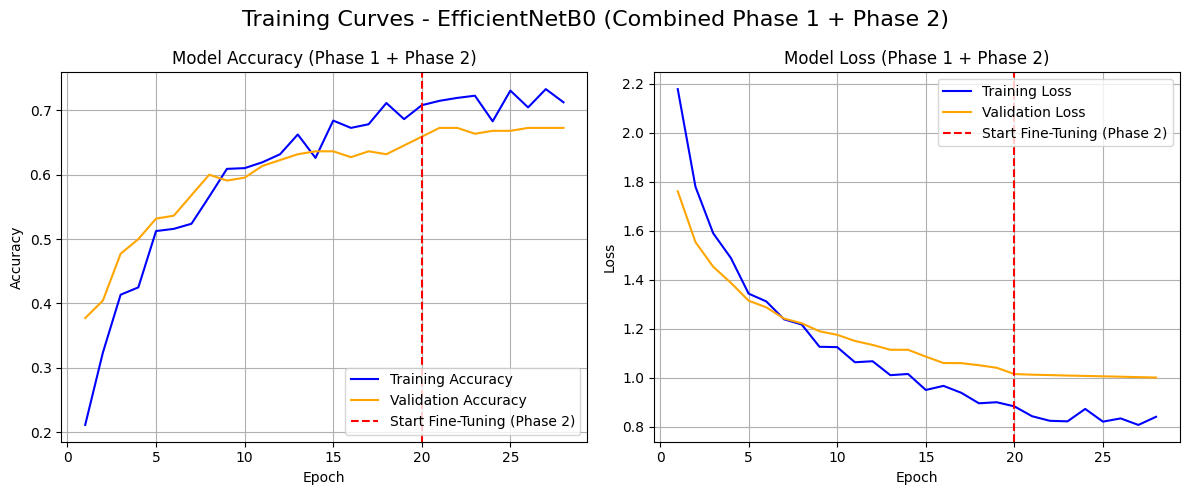

Best Validation Accuracy: 67.27% at Epoch 21
Phase 1 epochs: 1 to 20
Phase 2 starts at Epoch 21


In [39]:
import matplotlib.pyplot as plt

history_phase1 = history1  # ← Change to your Phase 1 history variable
history_phase2 = history_fine  # ← Change to your Phase 2 history variable

# Combine histories
history_combined = {}
history_combined['accuracy'] = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
history_combined['val_accuracy'] = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
history_combined['loss'] = history_phase1.history['loss'] + history_phase2.history['loss']
history_combined['val_loss'] = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

# Total epochs
total_epochs = range(1, len(history_combined['accuracy']) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(total_epochs, history_combined['accuracy'], label='Training Accuracy', color='blue')
plt.plot(total_epochs, history_combined['val_accuracy'], label='Validation Accuracy', color='orange')
plt.axvline(x=len(history_phase1.history['accuracy']), color='r', linestyle='--', label='Start Fine-Tuning (Phase 2)')
plt.title('Model Accuracy (Phase 1 + Phase 2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(total_epochs, history_combined['loss'], label='Training Loss', color='blue')
plt.plot(total_epochs, history_combined['val_loss'], label='Validation Loss', color='orange')
plt.axvline(x=len(history_phase1.history['accuracy']), color='r', linestyle='--', label='Start Fine-Tuning (Phase 2)')
plt.title('Model Loss (Phase 1 + Phase 2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.suptitle('Training Curves - EfficientNetB0 (Combined Phase 1 + Phase 2)', fontsize=16)
plt.tight_layout()
plt.show()

# Print best values
best_val_acc = max(history_combined['val_accuracy'])
best_epoch = history_combined['val_accuracy'].index(best_val_acc) + 1
print(f"Best Validation Accuracy: {best_val_acc * 100:.2f}% at Epoch {best_epoch}")
print(f"Phase 1 epochs: 1 to {len(history_phase1.history['accuracy'])}")
print(f"Phase 2 starts at Epoch {len(history_phase1.history['accuracy']) + 1}")

# **Confusion Matrix & Save Plot**

7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step
Test Accuracy: 67.27%

Classification Report:
                    precision    recall  f1-score   support

    Angelina Jolie       0.60      0.75      0.67        20
         Brad Pitt       0.85      0.55      0.67        20
 Jennifer Lawrence       0.50      0.70      0.58        20
       Johnny Depp       0.56      1.00      0.71        20
 Leonardo DiCaprio       0.65      0.65      0.65        20
   Natalie Portman       0.75      0.30      0.43        20
Scarlett Johansson       0.72      0.72      0.72        40
        Tom Cruise       0.56      0.45      0.50        20
         Tom Hanks       0.94      0.80      0.86        20
        Will Smith       0.88      0.75      0.81        20

          accuracy                           0.67       220
         macro avg       0.70      0.67      0.66       220
      weighted avg       0.70      0.67      0.67       220



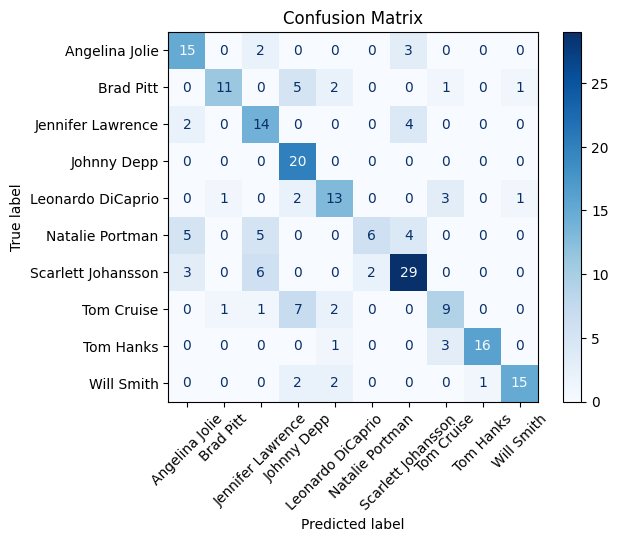

In [33]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_gen.classes  # True labels

# Class names (from your dataset)
class_names = list(test_gen.class_indices.keys())  # e.g., ['Angelina Jolie', 'Brad Pitt', ...]

# Overall accuracy
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Precision, Recall, F1 per class
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# **Grad-CAM**

Using last conv layer: top_conv


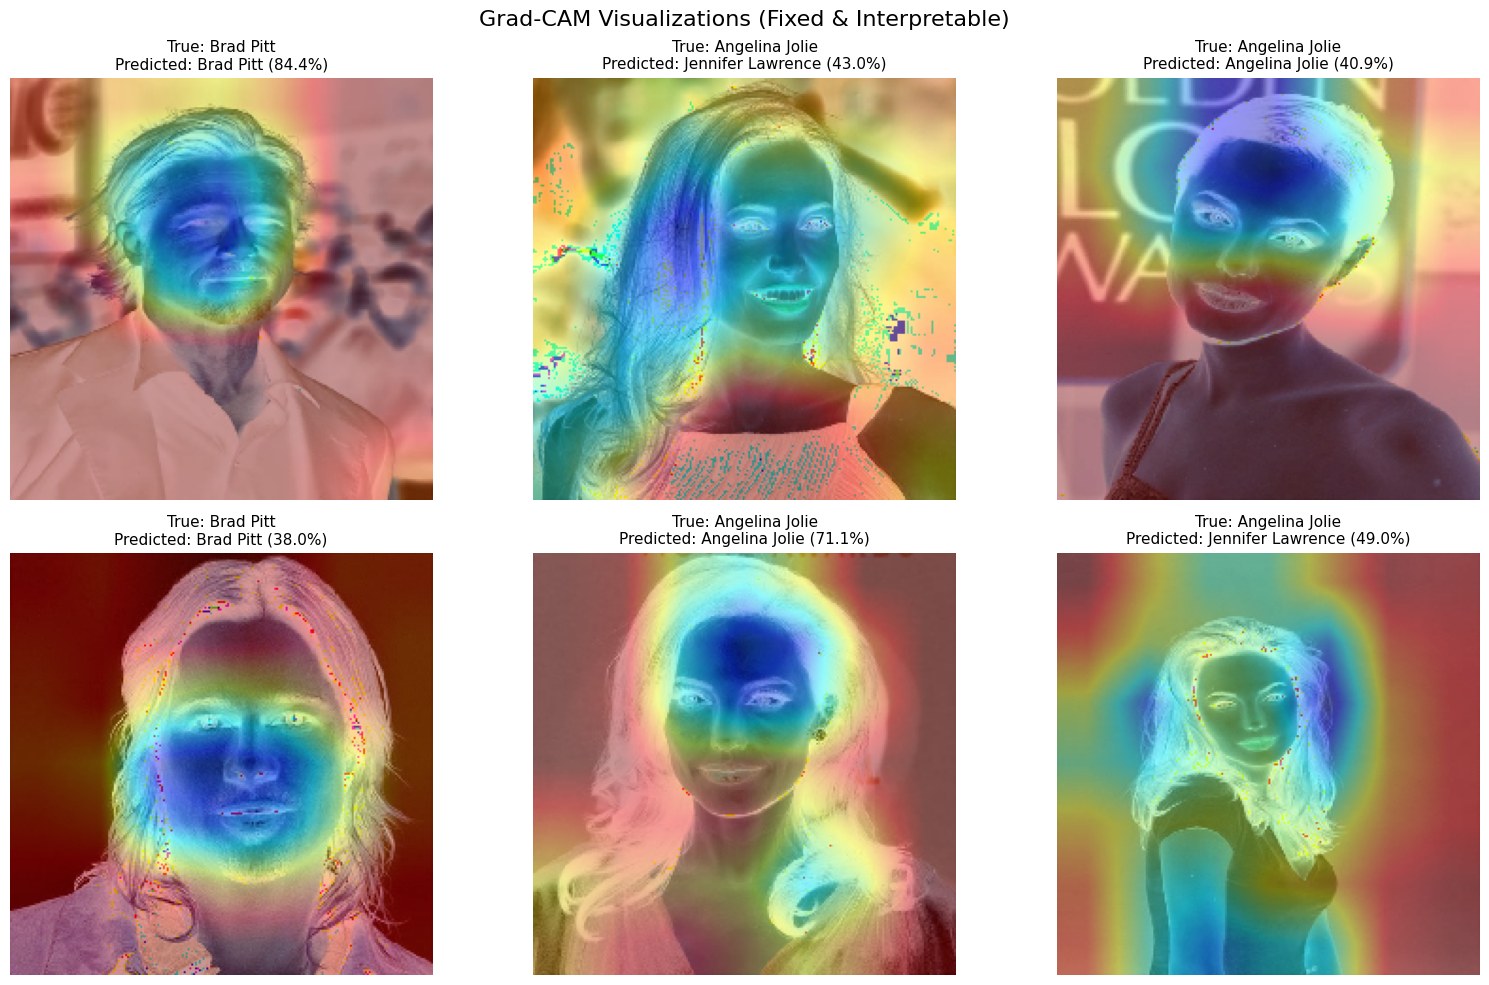

In [38]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

# -------------------------------------------------------
# 1. IDENTIFY LAST CONVOLUTIONAL LAYER (AUTO-DETECTION)
# -------------------------------------------------------
def get_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in the model.")

LAST_CONV_LAYER = get_last_conv_layer(model)
print("Using last conv layer:", LAST_CONV_LAYER)

# -------------------------------------------------------
# 2. GRAD-CAM FUNCTION (FIXED & STABLE)
# -------------------------------------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            model.output
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)

    # Channel-wise mean of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    # ReLU + normalize
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8

    return heatmap.numpy()

# -------------------------------------------------------
# 3. CLASS NAMES
# -------------------------------------------------------
class_names = list(test_gen.class_indices.keys())

# -------------------------------------------------------
# 4. GET TEST BATCH
# -------------------------------------------------------
test_gen.reset()
batch_images, batch_labels = next(test_gen)

num_examples = 6
plt.figure(figsize=(16, 10))

# -------------------------------------------------------
# 5. VISUALIZATION LOOP
# -------------------------------------------------------
for i in range(num_examples):
    idx = random.randint(0, batch_images.shape[0] - 1)

    img = batch_images[idx]
    img_batch = tf.expand_dims(img, axis=0)

    true_label = class_names[np.argmax(batch_labels[idx])]

    # Prediction
    preds = model.predict(img_batch, verbose=0)
    pred_idx = np.argmax(preds)
    pred_label = class_names[pred_idx]
    confidence = preds[0][pred_idx] * 100

    # Grad-CAM
    heatmap = make_gradcam_heatmap(
        img_batch,
        model,
        LAST_CONV_LAYER
    )

    # Resize heatmap
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.GaussianBlur(heatmap, (5, 5), 0)

    # Convert heatmap to color
    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(
        heatmap_uint8,
        cv2.COLORMAP_JET
    )

    # Convert image to uint8
    img_uint8 = np.uint8(img * 255)

    # Overlay
    superimposed = cv2.addWeighted(
        img_uint8, 0.6,
        heatmap_color, 0.4,
        0
    )

    # Plot
    plt.subplot(2, 3, i + 1)
    plt.imshow(superimposed)
    plt.title(
        f"True: {true_label}\n"
        f"Predicted: {pred_label} ({confidence:.1f}%)",
        fontsize=11
    )
    plt.axis("off")

# -------------------------------------------------------
# 6. FINAL DISPLAY
# -------------------------------------------------------
plt.suptitle(
    "Grad-CAM Visualizations (Fixed & Interpretable)",
    fontsize=16
)
plt.tight_layout()
plt.show()
